In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np

import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from models import VGG16, ResNet18

from solvers import *


import cupy as cp
from scipy.linalg import eigh

/opt/mambaforge/envs/landing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=False, transform=transform)

transform_MNIST = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset_MNIST = torchvision.datasets.MNIST(root='data', download=True, train=True, transform=transform_MNIST)

trainloader_MNIST = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
def VectorizeLeftImage(batch):
    data = [item[0][:,:,:14].reshape(-1).unsqueeze(0) for item in batch]
    return(torch.cat(data, dim = 0))

def VectorizeRightImage(batch):
    data = [item[0][:,:,14:].reshape(-1).unsqueeze(0) for item in batch]
    return(torch.cat(data, dim = 0))

loader_A = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=VectorizeLeftImage)
loader_B = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=VectorizeRightImage)

In [4]:
X, Y, AtA_full, BtB_full, AtB_full, out  = LandingCCA(loader_A, loader_B, p = 10, learning_rate = 1e-4, lambda_regul = 10,  n_epochs=100, device = torch.device('cuda'))

Objective: -0.15954
Dist X: 3.00003
Dist Y: 3.00001
Objective: -0.15979
Dist X: 3.00002
Dist Y: 3.00001
Objective: -0.16010
Dist X: 3.00002
Dist Y: 3.00001
Objective: -0.16076
Dist X: 3.00001
Dist Y: 3.00000
Objective: -0.16242
Dist X: 2.99998
Dist Y: 2.99996
Objective: -0.16708
Dist X: 2.99990
Dist Y: 2.99983
Objective: -0.18135
Dist X: 2.99962
Dist Y: 2.99933
Objective: -0.22733
Dist X: 2.99865
Dist Y: 2.99709
Objective: -0.36087
Dist X: 2.99453
Dist Y: 2.98495
Objective: -0.54537
Dist X: 2.97679
Dist Y: 2.93916
Objective: -0.71177
Dist X: 2.92794
Dist Y: 2.85654
Objective: -0.86007
Dist X: 2.84202
Dist Y: 2.76883
Objective: -0.94932
Dist X: 2.74268
Dist Y: 2.69176
Objective: -1.04608
Dist X: 2.64177
Dist Y: 2.64004
Objective: -1.15295
Dist X: 2.54602
Dist Y: 2.60871
Objective: -1.26092
Dist X: 2.44340
Dist Y: 2.56422
Objective: -1.35430
Dist X: 2.33950
Dist Y: 2.49483
Objective: -1.44052
Dist X: 2.26217
Dist Y: 2.41290
Objective: -1.55836
Dist X: 2.21457
Dist Y: 2.32853
Objective: -

In [ ]:
AtA = AtA_full.cpu().numpy()
BtB = BtB_full.cpu().numpy()
AtB = AtB_full.cpu().numpy()

X_cpu = X.detach().cpu().numpy()
Y_cpu = Y.detach().cpu().numpy()

In [51]:
AtAinv = np.linalg.inv(AtA+0.000005*np.eye(392,392))
BtBinv = np.linalg.inv(BtB+0.000005*np.eye(392,392))

In [52]:
# True solution:
d, u  = np.linalg.eig(AtAinv@AtB@BtBinv@AtB.T)
u1 = u[:,:10]
d, u  = np.linalg.eig(BtBinv@AtB.T@AtAinv@AtB)
u2 = u[:,:10]

In [53]:
u.shape

(392, 392)

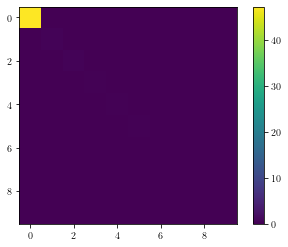

In [54]:
plt.imshow(np.abs(u1.T @ AtB @ u2))
plt.colorbar()

In [13]:
plt.rcParams.update({'text.usetex' : True})

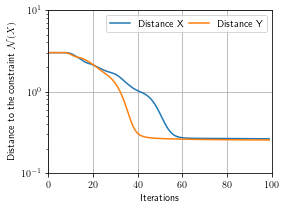

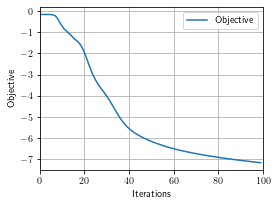

In [58]:
plt.figure(figsize=(4, 3))
plt.semilogy(out['distanceX'], label = 'Distance X')
plt.semilogy(out['distanceY'], label = 'Distance Y')
plt.xlim([0, 100])
plt.ylim([1e-1, 1e1])
x_ = plt.xlabel('Iterations')
y_ = plt.ylabel('Distance to the constraint $\mathcal{N}(X)$')
plt.grid()
plt.legend(ncol=2, loc='upper right', columnspacing=.5, handlelength=2)
plt.savefig('cca_distance.pdf', bbox_inches='tight', bbox_extra_artists=(x_, y_))

plt.figure(figsize=(4, 3))
plt.plot(np.array(out['objective']), label='Objective')
plt.xlim([0, 100])
x_ = plt.xlabel('Iterations')
y_ = plt.ylabel('Objective')
plt.legend(ncol=2, loc='upper right', columnspacing=.5, handlelength=2)

plt.grid()
plt.savefig('cca_objective.pdf', bbox_inches='tight', bbox_extra_artists=(x_, y_))



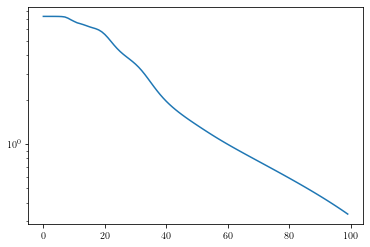

In [20]:
plt.semilogy(np.array(out['objective'])+7.5)

In [27]:
AtA = AtA_full.cpu().numpy()
BtB = BtB_full.cpu().numpy()
AtB = AtB_full.cpu().numpy()

X_cpu = X.detach().cpu().numpy()
Y_cpu = Y.detach().cpu().numpy()

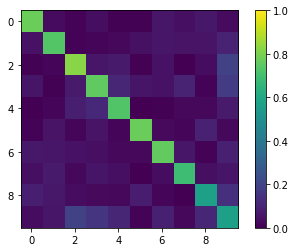

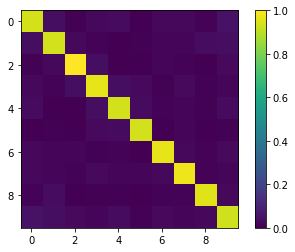

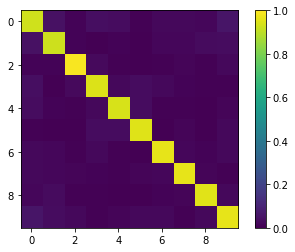

In [9]:
plt.imshow(np.abs(X_cpu.T @ AtB @ Y_cpu), clim=[0,1])
plt.colorbar()
plt.show()
plt.imshow(np.abs(X_cpu.T @ AtA @ X_cpu), clim=[0,1])
plt.colorbar()
plt.show()
plt.imshow(np.abs(Y_cpu.T @ BtB @ Y_cpu), clim=[0,1])
plt.colorbar()
plt.show()

In [25]:
np.linalg.norm(np.diag(AtB))

12.141672

In [27]:
AtB.shape

(392, 392)

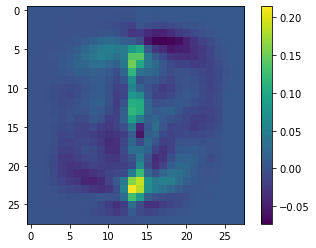

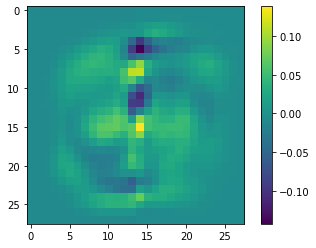

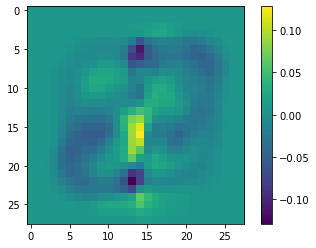

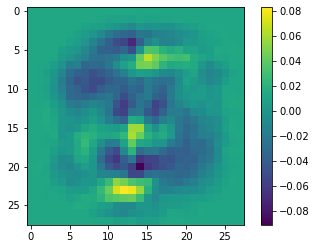

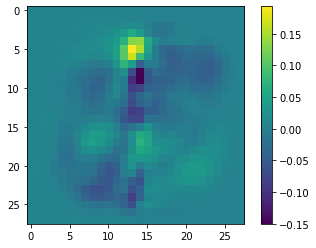

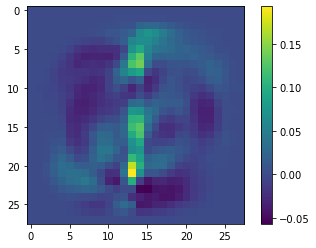

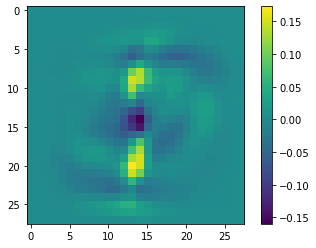

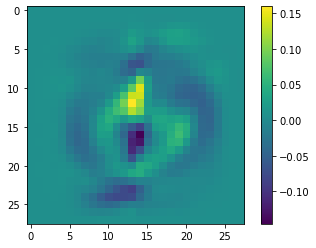

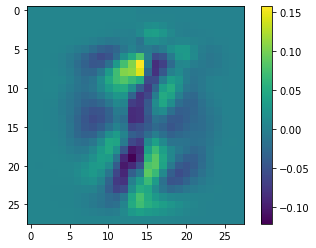

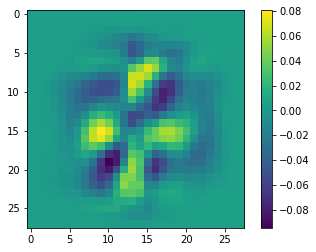

In [13]:
for i in range(10):
    x_tmp = (X_cpu[:,i]).reshape(28,-1)
    y_tmp = (Y_cpu[:,i]).reshape(28,-1)
    plt.imshow(np.concatenate([x_tmp,y_tmp],axis=1))
    plt.colorbar()
    plt.show()

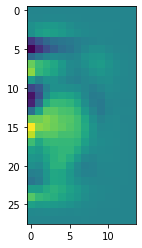

In [20]:
plt.imshow((Y_cpu[:,1]).reshape(28,-1))

In [8]:
(AtA@X_cpu).shape

(392, 10)

In [9]:
((AtA@X_cpu) @ (X_cpu.T @ AtA @ X_cpu - np.eye(10,10)))

array([[  920.11036875, -2085.72863305,    73.47406366, ...,
          -51.14708096,  -130.66572299,   723.7861788 ],
       [  920.11036875, -2085.72863305,    73.47406366, ...,
          -51.14708096,  -130.66572299,   723.7861788 ],
       [  920.11036875, -2085.72863305,    73.47406366, ...,
          -51.14708096,  -130.66572299,   723.7861788 ],
       ...,
       [  924.12707451, -2077.03577179,    83.54595979, ...,
          -53.66739613,  -124.3442831 ,   724.10880686],
       [  925.05992824, -2072.99607729,    85.97999375, ...,
          -55.178644  ,  -122.47910508,   723.33150251],
       [  925.23880473, -2069.96477653,    87.36572159, ...,
          -56.11967307,  -121.45809028,   722.52802804]])

In [ ]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(np.abs((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy()))
plt.colorbar()
plt.show()

print(torch.diag((features1 @ Q1).T @ (features2 @ Q2)))

In [3]:
n_epochs = 15
device = 'cuda'

model1 = VGG16()
model1.to(device)

optimizer1 = optim.SGD(model1.parameters(), lr=1e-1, weight_decay=5e-4)

model2 = VGG16()
model2.to(device)

optimizer2 = optim.SGD(model2.parameters(), lr=1e-1, weight_decay=5e-4)


In [4]:
def train(model, optimizer, n_epochs):
    best_test_acc = 0.
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            loss = model.loss(logits, batch_y)
            train_loss =+ loss.item() * batch_x.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(train_loss)

        # Test
        model.eval()
        with torch.no_grad():
            test_loss = 0.
            correct = 0.
            for batch_x, batch_y in testloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                logits = model(batch_x)
                loss = model.loss(logits, batch_y)
                test_loss += loss.item() * batch_x.size(0)
                correct += model.correct(logits, batch_y).item()
        print(100 * correct / len(testset))

train(model1, optimizer1, 50)
#train(model2, optimizer2, 8)

1773.303123474121
15.86
1374.267978668213
33.33
1244.390037536621
41.07


KeyboardInterrupt: 

In [4]:
#torch.save(model1, 'VGG16_1.pt')
#torch.save(model2, 'VGG16_2.pt')
model1 = torch.load('VGG16_1.pt')
model2 = torch.load('VGG16_2.pt')

In [5]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model1.features[10].register_forward_hook(get_activation('features1'))
model2.features[10].register_forward_hook(get_activation('features2'))

In [6]:
batch_idx, (batch_x, batch_y) = enumerate(trainloader).__next__()
batch_x, batch_y = batch_x.to(device), batch_y.to(device)


with torch.no_grad():
    _ = model1(batch_x)
    _ = model2(batch_x)
    features1 = activation['features1'].view((activation['features1'].shape[0],-1))
    features2 = activation['features2'].view((activation['features2'].shape[0],-1))
    features1 = (features1 - torch.mean(features1, dim=0))
    features2 = (features2 - torch.mean(features2, dim=0))

p = 20
_, S1, Q1 = torch.linalg.svd(features1, full_matrices=False)
_, S2, Q2 = torch.linalg.svd(features2, full_matrices=False)
Q1 = Q1[:p,:].T / S1[:p]
Q2 = Q2[:p,:].T / S2[:p]

best_test_acc = 0.
learning_rate = 1e-8
lambda_regul = 1
Q1 = torch.nn.Parameter(Q1)
Q2 = torch.nn.Parameter(Q2)

optimizerCCA = LandingGeneralizedStiefel((Q1,Q2), 
        lr=learning_rate, lambda_regul=lambda_regul)

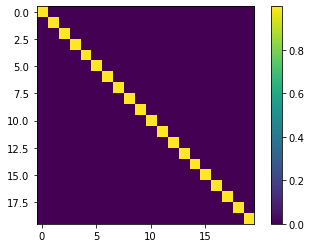

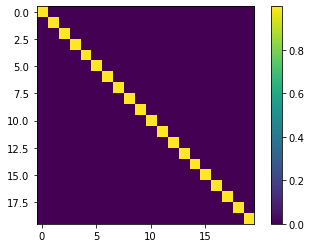

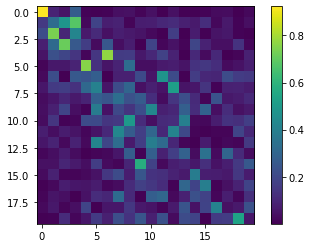

tensor([ 0.9232, -0.3281, -0.0975,  0.2592, -0.0148, -0.1336, -0.0028,  0.2133,
         0.2294,  0.2198,  0.0368, -0.1025, -0.1010,  0.2862, -0.0598,  0.0766,
         0.0082, -0.0771,  0.0641, -0.0572], device='cuda:0',
       grad_fn=<DiagBackward0>)


In [7]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(np.abs((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy()))
plt.colorbar()
plt.show()

print(torch.diag((features1 @ Q1).T @ (features2 @ Q2)))

In [8]:
for g in optimizerCCA.param_groups:
      g['lr'] = g['lr'] / 10
      g['lambda_regul'] = g['lambda_regul']

In [9]:
for epoch in range(20):
    model1.eval()
    model2.eval()
    train_loss = 0
    dist1 = torch.zeros(p,p, device = device)
    dist2 = torch.zeros(p,p, device = device)
    for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            _ = model1(batch_x)
            _ = model2(batch_x)
            features1 = activation['features1'].view((activation['features1'].shape[0],-1))
            features2 = activation['features2'].view((activation['features2'].shape[0],-1))
            features1 = (features1 - torch.mean(features1, dim=0))
            features2 = (features2 - torch.mean(features2, dim=0))
        loss = -torch.trace( (Q1.T @ features1.T) @ (features2 @ Q2)) /  (batch_x.size(0))
        train_loss =+ loss.item() * batch_x.size(0)
        dist1 += (features1 @ Q1).T @ (features1 @ Q1) 
        dist2 += (features2 @ Q2).T @ (features2 @ Q2)
        optimizerCCA.zero_grad()
        loss.backward()
        optimizerCCA.step(((features1, features2 ),))
    print('Objective: %2.5f' % train_loss)
    print('Dist Q1: %2.5f' % (torch.linalg.norm(dist1 - torch.eye(p,p, device = device)).item() / len(trainloader)))
    print('Dist Q2: %2.5f' % (torch.linalg.norm(dist2 - torch.eye(p,p, device = device)).item() /len(trainloader)) )

Objective: -9.61416
Dist Q1: 3.65003
Dist Q2: 3.80091
Objective: -11.50668
Dist Q1: 3.65394
Dist Q2: 3.85008
Objective: -12.63437
Dist Q1: 3.65651
Dist Q2: 3.83800
Objective: -13.01447
Dist Q1: 3.65966
Dist Q2: 3.82516
Objective: -13.49870
Dist Q1: 3.66194
Dist Q2: 3.81374
Objective: -13.58173
Dist Q1: 3.66460
Dist Q2: 3.80699
Objective: -13.77267
Dist Q1: 3.66724
Dist Q2: 3.80016
Objective: -13.37390
Dist Q1: 3.66966
Dist Q2: 3.79381
Objective: -13.87409
Dist Q1: 3.67225
Dist Q2: 3.78871
Objective: -13.73200
Dist Q1: 3.67494
Dist Q2: 3.78571
Objective: -13.83156
Dist Q1: 3.67704
Dist Q2: 3.78237
Objective: -13.64179
Dist Q1: 3.68011
Dist Q2: 3.77989
Objective: -13.66645
Dist Q1: 3.68256
Dist Q2: 3.77719
Objective: -13.82600
Dist Q1: 3.68515
Dist Q2: 3.77541
Objective: -13.63936
Dist Q1: 3.68733
Dist Q2: 3.77366
Objective: -13.83434
Dist Q1: 3.68974
Dist Q2: 3.77330
Objective: -13.85437
Dist Q1: 3.69237
Dist Q2: 3.77259
Objective: -13.80661
Dist Q1: 3.69492
Dist Q2: 3.77249
Objective: 

In [3]:
def VectorizeImage(batch):
    data = [item[0].view(-1).unsqueeze(1)[:500] for item in batch]
    return(torch.cat(data, dim = 1))

loader_A = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=VectorizeImage)

In [6]:
LandingCCA(iter(loader_A), iter(loader_A), p = 10, learning_rate = 1e-3, lambda_regul = 1,  n_epochs=5, device = 'cuda')

KeyboardInterrupt: 

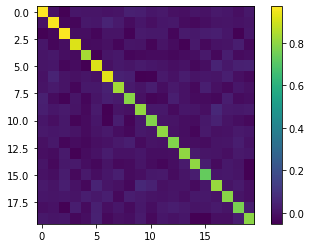

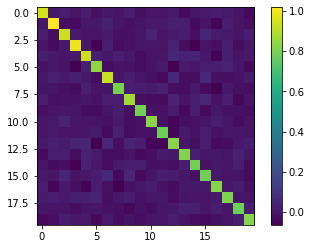

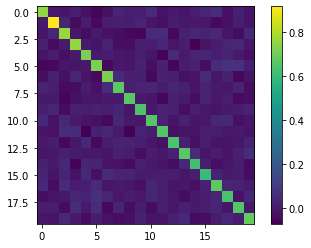

In [10]:
plt.imshow(dist1.cpu().detach().numpy()/len(trainloader))
plt.colorbar()
plt.show()

plt.imshow(dist2.cpu().detach().numpy()/len(trainloader))
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

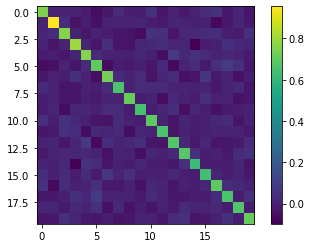

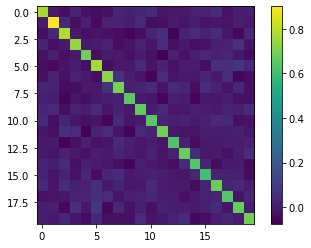

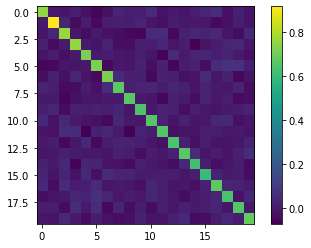

In [12]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
torch.diag(Q1.T @ features1.T@ features2 @ Q2).sum()

tensor(25.3942, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
torch.linalg.norm(features1 @ features2.T)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (848x32768 and 16384x848)

In [ ]:
torch.linalg.norm(features1 @ Q1 @ Q2.T @ features2.T)

tensor(1.7435, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
(features1 @ Q1 @ Q2.T @ features2.T).shape

torch.Size([80, 80])

In [ ]:
(features1 @ features2.T).shape

torch.Size([80, 80])

In [217]:
x_true = B_sqrt_inv  @ uG[:,:p]

NameError: name 'B_sqrt_inv' is not defined

In [204]:
torch.linalg.norm((features1 @ Q1).T @ (features1 @ Q1) - torch.eye(p,p, device = device))

tensor(4.3785, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [218]:
torch.diag((features1 @ Q1).T @ (features2 @ Q2))

tensor([0.3751, 0.4544, 0.3530, 0.4672, 0.3098, 0.4153, 0.3651, 0.4537, 0.3104,
        0.4110, 0.4458, 0.3260, 0.3644, 0.4497, 0.4044, 0.4983, 0.4550, 0.3374,
        0.3649, 0.3223, 0.4536, 0.3510, 0.5946, 0.3729, 0.4212, 0.4352, 0.5927,
        0.4242, 0.3799, 0.4061, 0.4219, 0.4915, 0.3397, 0.4305, 0.4621, 0.5205,
        0.3581, 0.3714, 0.3048, 0.3836], device='cuda:0',
       grad_fn=<DiagBackward0>)

In [219]:
torch.trace( (features1).T @ features2 )

tensor(-17784.1172, device='cuda:0')

In [321]:
torch.trace( (features1 @ Q1).T @ features2 @ Q2) / 40

tensor(0.6224, device='cuda:0', grad_fn=<DivBackward0>)

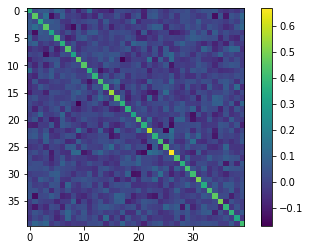

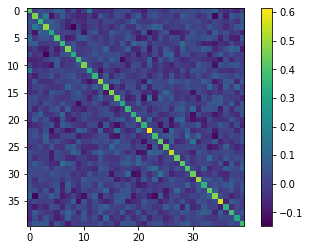

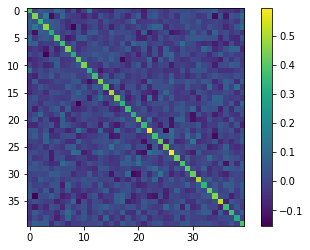

In [221]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

In [246]:
torch.trace(Q1.T @ features1.T@ features2 @ Q2)

tensor(6.8522, device='cuda:0', grad_fn=<TraceBackward0>)

In [19]:
(features1 @ Q1).T @ 

torch.Size([80, 40])

In [53]:
D1 = (features1 @ Q1).cpu().detach().numpy()
D2 = (features2 @ Q2).cpu().detach().numpy()

D1 = (D1 - D1.mean(axis=0)) #  / D1.std(axis=0) 
D2 = (D2 - D2.mean(axis=0)) # / D2.std(axis=0)
Cov12 = D1.T @ D2 / D1.shape[0]


In [55]:
from scipy.stats import pearsonr

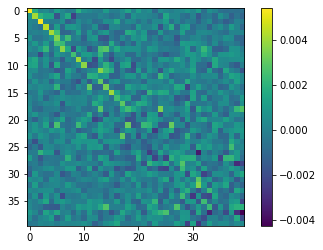

In [54]:
plt.imshow(Cov12 / ())
plt.colorbar()

In [56]:
torch.corrcoef((features1 @ Q1).T, (features2 @ Q2).T)

TypeError: corrcoef() takes 1 positional argument but 2 were given

In [17]:
Q1.shape

torch.Size([32768, 40])

In [244]:
(features1 * features1).sum()

tensor(2588672., device='cuda:0')

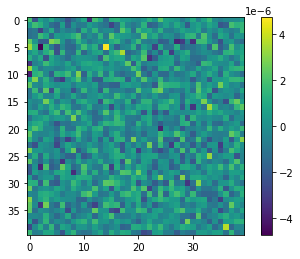

In [245]:
plt.imshow((Q1.T @ Q2).cpu().detach().numpy())
plt.colorbar()

In [17]:
for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            features1 = model1.features(batch_x).squeeze()
            features2 = model2.features(batch_x).squeeze()
        covXY += features1.T @ features2 / batch_x.size(0)
        covX += features1.T @ features1 / batch_x.size(0)
        covY += features2.T @ features2 / batch_x.size(0)

In [41]:
len(trainloader.dataset)

50000

In [18]:
loss = -.5*torch.trace( Q1.T @ features1.T @ features2 @ Q2)

In [22]:
loss.backward()

In [23]:
optimizerCCA.step(((features1.T@ features1, features2.T@ features2),))

In [25]:
train_loss =+ loss.item() * batch_x.size(0)

In [34]:
loss.item()

-0.34627026319503784

In [36]:
-.5*torch.trace( Q1.T @ features1.T @ features2 @ Q2)

tensor(-0.3463, device='cuda:0', grad_fn=<MulBackward0>)

In [18]:
trainloader_enum = enumerate(trainloader)

In [33]:
i, (batch_x, batch_y) = trainloader_enum.__next__()
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

In [87]:
A1 = model1.features(batch_x)[:,:,0,0].cpu().detach().numpy()
A2 = model1.features(batch_x)[:,:,0,0].cpu().detach().numpy()

In [142]:
n = 512
p = 10
Q1 = torch.randn(n, p, device = device, requires_grad=True)
Q2 = torch.randn(n, p, device = device, requires_grad=True)

In [145]:
optimizer_cca = optim.SGD((Q1, Q2), lr=1e-6)

In [147]:
best_test_acc = 0.
model1.eval()
model2.eval()
for epoch in range(n_epochs):
    train_loss = 0.0
    for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        A1 = model1.features(batch_x)[:,:,0,0].detach()
        A2 = model2.features(batch_x)[:,:,0,0].detach()
        loss = - torch.trace(Q1.T@ (A1.T @ A2) @ Q2)
        train_loss =+ loss.item() * batch_x.size(0)
        optimizer_cca.zero_grad()
        loss.backward()
        optimizer_cca.step()
        with torch.no_grad():
            Q1,_ = torch.linalg.qr(Q1)
            Q2,_ = torch.linalg.qr(Q2)
        Q1.requires_grad = True
        Q2.requires_grad = True
    print(train_loss/len(trainset))

-11.53541328125
-12.8180953125
-10.70384453125
-10.55670625
-10.276184375
-11.49911875
-10.47547421875
-10.5956484375
-9.82373359375
-9.57715546875
-10.41351875
-10.265225
-10.7919796875
-10.0132453125
-9.96588125


In [139]:
Q1.T@Q1

tensor([[ 1.0000e+00,  5.5879e-09, -2.7940e-09, -9.3132e-09,  9.3132e-10,
          4.6566e-09, -8.8476e-09, -1.2107e-08, -1.9558e-08, -5.5879e-09],
        [ 5.5879e-09,  1.0000e+00,  3.2596e-09,  1.1642e-09,  6.7521e-09,
          3.7253e-09, -5.1223e-09, -1.8626e-09, -2.7940e-09,  1.0245e-08],
        [-2.7940e-09,  3.2596e-09,  1.0000e+00, -2.3283e-10, -8.3819e-09,
          4.1910e-09, -1.3970e-08, -3.2596e-09, -9.3132e-10, -6.5193e-09],
        [-9.3132e-09,  1.1642e-09, -2.3283e-10,  1.0000e+00, -1.5600e-08,
          0.0000e+00,  1.8626e-09,  4.6566e-10,  2.3283e-10,  4.6566e-10],
        [ 9.3132e-10,  6.7521e-09, -8.3819e-09, -1.5600e-08,  1.0000e+00,
         -4.6566e-10, -8.3819e-09,  4.6566e-09,  5.5879e-09,  3.7253e-09],
        [ 4.6566e-09,  3.7253e-09,  4.1910e-09,  0.0000e+00, -4.6566e-10,
          1.0000e+00,  2.4680e-08,  2.7940e-09, -5.5879e-09,  3.2596e-09],
        [-8.8476e-09, -5.1223e-09, -1.3970e-08,  1.8626e-09, -8.3819e-09,
          2.4680e-08,  1.0000e+0

In [89]:
from sklearn.cross_decomposition import CCA

In [96]:
cca = CCA(n_components=10)
cca.fit(A1, A2)

CCA(n_components=10)

In [99]:
cca.score(A1, A2)

0.5813387144987419

In [92]:
X_c, Y_c = cca.transform(A1, A2)

In [75]:
(U, S, V) = torch.pca_lowrank(A1.T@A2, q = 100, center=True, niter=20)

In [84]:
S.cpu().detach().numpy()[:50]

array([1.0347093e+04, 5.0820493e+03, 3.5821323e+03, 2.9084653e+03,
       2.4939863e+03, 1.8302538e+03, 1.3989786e+03, 1.1476134e+03,
       8.5155157e+02, 6.2643530e+02, 2.4559721e+02, 7.1573997e+01,
       5.0670170e+01, 4.8174137e+01, 4.1952473e+01, 3.7283165e+01,
       3.6203281e+01, 3.1056530e+01, 2.5350792e+01, 2.4845078e+01,
       2.2801348e+01, 2.0585983e+01, 1.9518456e+01, 1.7976635e+01,
       1.6180603e+01, 1.5687751e+01, 1.3683533e+01, 1.2015533e+01,
       1.0651150e+01, 1.0012889e+01, 9.1580162e+00, 8.3238554e+00,
       7.8208060e+00, 7.5031281e+00, 6.8287992e+00, 6.1659822e+00,
       5.9519992e+00, 5.1096954e+00, 4.9533033e+00, 4.3717241e+00,
       4.1098890e+00, 3.8927417e+00, 3.5315640e+00, 3.5272615e+00,
       3.4553266e+00, 3.2666328e+00, 3.1249063e+00, 3.0096223e+00,
       2.7635863e+00, 2.6369815e+00], dtype=float32)

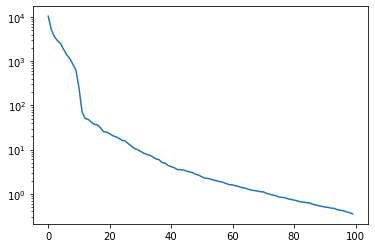

In [82]:
plt.semilogy(S.cpu().detach().numpy())

In [69]:
A1.shape

torch.Size([128, 512])

In [23]:
trainloader.batch_size

128

In [32]:
batch_x.shape

torch.Size([128, 3, 32, 32])